# CIS6800: Project 3: SOLO and FPN (Instance Segmentation)
### Due:
* Part (a) Oct. 1 at 11:59 p.m.
* Part (b) Oct. 8 at 11:59 p.m.

### Instructions:
* This is a group assignment with one submission per group. It is expected that each member of the group will contribute to solving each question. Be sure to specify your teammates when you submit to Gradescope! Collaborating with other groups is not permitted.
* There is no single answer to most problems in deep learning, therefore the questions will often be underspecified. You need to fill in the blanks and submit a solution that solves the (practical) problem. Document the choices (hyperparameters, features, neural network architectures, etc.) you made where specified.
* All the code should be written in Python.
* You may include any code used in previous projects. You may use ChatGPT, but you need to document how you use it.
* You should expect that a complete training session should last about 6 hours, so you should start part (b) as early as you can!
* To save on compute time, we debugging locally and using colab to train. Or use colab cpu instance for debugging
* We should be able to reproduce your results with a single function call or cell evaluation. Please specify the method to do so. You do not, however, need to submit your trained weights.


The SOLO paper: https://arxiv.org/pdf/1912.04488.pdf


In [1]:
# download data, you can maunally download dataset set here:
# https://drive.google.com/drive/folders/1eP7FtPaWfJ5zLdcsZYl6eyn5EYixkFn8

!gdown --id 1JD3OaHpq_4KCb7ofcPMkknmdEXFHrCcn
!gdown --id 1ssRA7yijGLFmJU-ac-lPyUOq7DYzTAS1
!gdown --id 1Rpz-ZuQxDwvLyzc0FD9GZxAKlyka3VC5
!gdown --id 1ouMFNT1thia8l6P5vcWCY-nweAexLDsB
!pip install pytorch-lightning

'gdown' is not recognized as an internal or external command,
operable program or batch file.
'gdown' is not recognized as an internal or external command,
operable program or batch file.
'gdown' is not recognized as an internal or external command,
operable program or batch file.
'gdown' is not recognized as an internal or external command,
operable program or batch file.



[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip


## Code Structure
In this assignment, we are only providing the barest templates for your code structure. If you prefer, you can write and debug most of the components in a regular python and only use Jupyter to train. In this case, you might have several files that you import into this notebook, e.g.
* `dataset.py`
* `model.py`
* `train.py`
* `inference.py`

This is shown below. All files should be included in your submission.

In [2]:
try:
    import dataset as dt
    # import model
    # import train
    # import inference
    import backbone
except ModuleNotFoundError:
    pass

## Overview

Instance segmentation can be thought of as a combination of object detection and semantic segmentation, the former of which you already explored in the previous project. A visulization of this relationship can be seen in fig. 1.

<div><img src="https://github.com/LukasZhornyak/CIS680_files/raw/main/HW3/fig1.png" width=500/></div>
<center>Figure 1: An overview of instance segmentation.</center>

In this project, you are tasked with implementing an instance segmentation framework know as SOLO (Segmenting Object by LOcations). In a similar manner to YOLO, SOLO produces mask predictions on a dense grid. This means that, unlike many other segmenation frameworks (e.g. Mask-RCNN), SOLO directly predicts the segmentation mask without proposing bounding box locations. An visual summary of SOLO can be seen in fig. 2 and 3.

<div><img src="https://github.com/LukasZhornyak/CIS680_files/raw/main/HW3/fig2.png" width=200/></div>
<center>Figure 2: SOLO.</center>

<div><img src="https://github.com/LukasZhornyak/CIS680_files/raw/main/HW3/fig3.png" width=600/></div>
<center>Figure 3: SOLO branches.</center>

These dense predictions are produced at several different scales using a Feature Pyramid Network (FPN). Using the last few layers of the backbone, we pass the higher level features from the deeper layers back up to larger features scales using lateral connections, shown in fig. 4. The integration of the FPN into your network will be the primary focus of this project.

<div><img src="https://github.com/LukasZhornyak/CIS680_files/raw/main/HW3/fig4.png" width=300/></div>
<center>Figure 4: SOLO branches.</center>

## Part A

### Dataset
#### Dataset Structure
The dataset used in this project contains three classes across 3265 images: vehicles, people, and animals. The dataset contains the following elements:

* A numpy array of images ($3 \times 300 \times 400$).
* A numpy array of masks ($300 \times 400$).
* A list of ground truth labels by image.
* A list of bounding boxes by image.

Note that the mask array is flattened; to determine which masks belong to which image, count the number of labels associated with that image. For example, if the first few images have 3, 2, and 4 labels, masks 0-2 would belong to image 1, masks 3-4 would belong to image 2, etc. The masks are ordered correctly to allow for this.

#### Loading and Batching
You should apply the following transformations to each image:
* Normalize pixel values to $[0,1]$.
* Rescale the image to $800 \times 1066$.
* Normalize each channel with means $[0.485, 0.456, 0.406]$ and standard deviations $[0.229, 0.224, 0.225]$.
* Zero pad the image to $800 \times 1088$.

Since each image will have a different number of objects, you will have to write your own collation function to properly batch the images. An example collate_fn is shown below, along with expected output dimensions.

In [3]:
# images:         (batch_size, 3, 800, 1088)
# labels:         list with len: batch_size, each (n_obj,)
# masks:          list with len: batch_size, each (n_obj, 800,1088)
# bounding_boxes: list with len: batch_size, each (n_obj, 4)
def collate_fn(batch):
    images, labels, masks, bounding_boxes = list(zip(*batch))
    return torch.stack(images), labels, masks, bounding_boxes

#### Visualization
In order to validate that you are loading the dataset correct, you should plot at least five example images that include the mask, annotations, and bounding boxes. Examples of such images are shown in fig. 5 and 6. Make sure that the color for each class is consistent!

<div><img src="https://github.com/LukasZhornyak/CIS680_files/raw/main/HW3/fig5.png" width=500/></div>
<center>Figure 5: Example visualization.</center>

<div><img src="https://github.com/LukasZhornyak/CIS680_files/raw/main/HW3/fig6.png" width=500/></div>
<center>Figure 6: Example visualization.</center>

### Model
#### Architecture
The model architecture is summarized in fig. 7 and tables 1 and 2.

<div><img src="https://github.com/LukasZhornyak/CIS680_files/raw/main/HW3/fig7.png" width=500/></div>
<center>Figure 7: SOLO branch structure.</center>
<br>
<center>Table 1: Category branch structure.</center>

| Layer | Hyperparameters |
| :--- | :--- |
| conv1 | Kernel size $= 3\times3\times256$, stride $= 1$, pad $= 1$, bias $= \text{False}$. <br> Followed by GroupNorm, num_groups $=32$ and ReLU |
| conv2 | Kernel size $= 3\times3\times256$, stride $= 1$, pad $= 1$, bias $= \text{False}$. <br> Followed by GroupNorm, num_groups $=32$ and ReLU |
| conv3 | Kernel size $= 3\times3\times256$, stride $= 1$, pad $= 1$, bias $= \text{False}$. <br> Followed by GroupNorm, num_groups $=32$ and ReLU |
| conv4 | Kernel size $= 3\times3\times256$, stride $= 1$, pad $= 1$, bias $= \text{False}$. <br> Followed by GroupNorm, num_groups $=32$ and ReLU |
| conv5 | Kernel size $= 3\times3\times256$, stride $= 1$, pad $= 1$, bias $= \text{False}$. <br> Followed by GroupNorm, num_groups $=32$ and ReLU |
| conv6 | Kernel size $= 3\times3\times256$, stride $= 1$, pad $= 1$, bias $= \text{False}$. <br> Followed by GroupNorm, num_groups $=32$ and ReLU |
| conv7 | Kernel size $= 3\times3\times256$, stride $= 1$, pad $= 1$, bias $= \text{False}$. <br> Followed by GroupNorm, num_groups $=32$ and ReLU |
| conv_out | Kernel size $= 3\times3\times(C-1)$, stride $= 1$, pad $= 1$, bias $= \text{True}$. <br> Followed by Sigmoid layer. Note $C = 4$ here (number of classes + background). |

<br>
<center>Table 2: Mask branch structure.</center>

| Layer | Hyperparameters |
| :--- | :--- |
| conv1 | Kernel size $= 3\times3\times(256 + 2)$, stride $= 1$, pad $= 1$, bias $= \text{False}$. <br> Two additional input channels represent the $x$ and $y$ positional encoding. <br> Followed by GroupNorm, num_groups $=32$ and ReLU |
| conv2 | Kernel size $= 3\times3\times256$, stride $= 1$, pad $= 1$, bias $= \text{False}$. <br> Followed by GroupNorm, num_groups $=32$ and ReLU |
| conv3 | Kernel size $= 3\times3\times256$, stride $= 1$, pad $= 1$, bias $= \text{False}$. <br> Followed by GroupNorm, num_groups $=32$ and ReLU |
| conv4 | Kernel size $= 3\times3\times256$, stride $= 1$, pad $= 1$, bias $= \text{False}$. <br> Followed by GroupNorm, num_groups $=32$ and ReLU |
| conv5 | Kernel size $= 3\times3\times256$, stride $= 1$, pad $= 1$, bias $= \text{False}$. <br> Followed by GroupNorm, num_groups $=32$ and ReLU |
| conv6 | Kernel size $= 3\times3\times256$, stride $= 1$, pad $= 1$, bias $= \text{False}$. <br> Followed by GroupNorm, num_groups $=32$ and ReLU |
| conv7 | Kernel size $= 3\times3\times256$, stride $= 1$, pad $= 1$, bias $= \text{False}$. <br> Followed by GroupNorm, num_groups $=32$ and ReLU |
| conv_out | Kernel size $= 1\times1\times(\text{num_grid})^2$, stride $= 1$, pad $= 0$, bias $= \text{True}$. <br> Followed by Sigmoid layer. Note that $\text{num_grid}$ is different for each layer of the FPN. |

We will be using a pretrained backbone (which includes an FPN), so you will not have to implement those components. A template for the network with along with default parameters is shown below.

#### Feature Pyramid
The feature pyramid extracted below has strides $[4,8,16,32,64]$ over the original image. To match the SOLO paper, this should be interpolated to have strides $[8,8,16,32,32]$.

#### Target Assignment
Some notes about generating the ground truth targets:
* The FPN levels can be though of as different grid sizes cut through the image.
* You assign each target to a certain FPN level if $\sqrt{wh}$ from the bounding box falls within the `scale_range` associated with that level. Note that these overlap, so you may assign the same target to multiple levels.
* A grid cell should be considered as predicting an object if that grid cell falls into the "centre region" of the object.
 * The centre region of an object is its bounding box scaled by `epsilon`.
 * Each grid cell can predict at most one object, but each object can be predicted by more than one grid cell.

#### Target Visualization
You should produce visualizations such as fig. 8 and 9 to validate your target assignments.

<div><img src="https://github.com/LukasZhornyak/CIS680_files/raw/main/HW3/fig8.png" width=500/></div>
<center>Figure 8: Target assignment example.</center>

<div><img src="https://github.com/LukasZhornyak/CIS680_files/raw/main/HW3/fig9.png" width=500/></div>
<center>Figure 9: Target assignment example.</center>

In [4]:
!pip install pytorch-lightning


[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [5]:
import torch.nn.functional as F
import torch
import torchvision
import pytorch_lightning as pl
from torch import nn
from matplotlib import pyplot as plt
import copy

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [7]:
class SOLO(pl.LightningModule):
    _default_cfg = {
        'num_classes': 4,
        'in_channels': 256,
        'seg_feat_channels': 256,
        'stacked_convs': 7,
        'strides': [8, 8, 16, 32, 32],
        'scale_ranges': [(1, 96), (48, 192), (96, 384), (192, 768), (384, 2048)],
        'epsilon': 0.2,
        'num_grids': [40, 36, 24, 16, 12],
        'mask_loss_cfg': dict(weight=3),
        'cate_loss_cfg': dict(gamma=2, alpha=0.25, weight=1),
        'postprocess_cfg': dict(cate_thresh=0.2, mask_thresh=0.5, pre_NMS_num=50, keep_instance=5, IoU_thresh=0.5)
    }

    def __init__(self, **kwargs):
        super().__init__()
        for k, v in {**self._default_cfg, **kwargs}.items():
            setattr(self, k, v)

        pretrained_model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=False, pretrained_backbone=True)
        self.backbone = pretrained_model.backbone

        # category branch
        # repeat 1 - 7 convs
        self.cat_conv_rep = nn.Sequential(
            nn.Conv2d(in_channels= self._default_cfg['in_channels'], out_channels= self._default_cfg['seg_feat_channels'], kernel_size=3, stride=1, padding=1, bias=False),
            nn.GroupNorm(num_groups=32, num_channels= self._default_cfg['seg_feat_channels']),
            nn.ReLU()
        )

        # conv_out
        self.cat_conv_out = nn.Sequential(
            nn.Conv2d(in_channels= self._default_cfg['seg_feat_channels'], out_channels= self._default_cfg['num_classes'] - 1, kernel_size=3, stride=1, padding=1, bias=True)
        )


        self.category_branch = nn.Sequential()
        for i in range(7):
            self.category_branch.add_module(f"conv_rep_{i+1}", self.cat_conv_rep)
        self.category_branch.add_module("conv_out", self.cat_conv_out)


        # mask branch
        self.mask_conv1 = nn.Sequential(
            nn.Conv2d(in_channels= self._default_cfg['in_channels'] + 2, out_channels= self._default_cfg['seg_feat_channels'], kernel_size=3, stride=1, padding=1, bias=False),
            nn.GroupNorm(num_groups=32, num_channels= self._default_cfg['seg_feat_channels']),
            nn.ReLU()
        )

        # repeat 2-7 convs
        self.mask_conv2 = nn.Sequential(
            nn.Conv2d(in_channels= self._default_cfg['seg_feat_channels'], out_channels= self._default_cfg['seg_feat_channels'], kernel_size=3, stride=1, padding=1, bias=False),
            nn.GroupNorm(num_groups=32, num_channels= self._default_cfg['seg_feat_channels']),
            nn.ReLU()
        )

        self.mask_conv_out = nn.ModuleList([
            nn.Sequential(
                nn.Conv2d(in_channels= self._default_cfg['seg_feat_channels'], out_channels= grid * 2, kernel_size=1, stride=1, padding=0, bias=True),
                nn.Sigmoid()
            ) for grid in self._default_cfg['num_grids']])

        self.mask_branch = nn.Sequential()
        self.mask_branch.add_module("mask_conv1", self.mask_conv1)
        for i in range(6):
            self.mask_branch.add_module(f"mask_conv{i+2}", self.mask_conv2)

        self.mask_branch.add_module("mask_conv_out", self.mask_conv_out)

    # Forward function should calculate across each level of the feature pyramid network.
    # Input:
    #     images: batch_size number of images
    # Output:
    #     if eval = False
    #         category_predictions: list, len(fpn_levels), each (batch_size, C-1, S, S)
    #         mask_predictions:     list, len(fpn_levels), each (batch_size, S^2, 2*feature_h, 2*feature_w)
    #     if eval==True
    #         category_predictions: list, len(fpn_levels), each (batch_size, S, S, C-1)
    #         / after point_NMS
    #         mask_predictions:     list, len(fpn_levels), each (batch_size, S^2, image_h/4, image_w/4)
    #         / after upsampling
    def forward(self, images, eval=True):
        # you can modify this if you want to train the backbone
        feature_pyramid = [v.detach() for v in self.backbone(images).values()] # this has strides [4,8,16,32,64]

    # This function build the ground truth tensor for each batch in the training
    # Input:
    #     bounding_boxes:   list, len(batch_size), each (n_object, 4) (x1 y1 x2 y2 system)
    #     labels:           list, len(batch_size), each (n_object, )
    #     masks:            list, len(batch_size), each (n_object, 800, 1088)
    # Output:
    #     category_targets: list, len(batch_size), list, len(fpn), (S, S), values are {1, 2, 3}
    #     mask_targets:     list, len(batch_size), list, len(fpn), (S^2, 2*feature_h, 2*feature_w)
    #     active_masks:     list, len(batch_size), list, len(fpn), (S^2,)
    #     / boolean array with positive mask predictions
    def generate_targets(self, bboxes, labels, masks):
            img_height, img_width = 800, 1088
            num_levels = 5
            num_images = len(labels)
            
            #first we create empty nested lists that will store the final targets for each image
            category_targets = []
            mask_targets = []
            active_masks = []
            active_levels = []

            for _ in range(num_images):
                category_targets.append([[] for i in range(num_levels)])
                mask_targets.append([[] for i in range(num_levels)])
                active_masks.append([[] for i in range(num_levels)])
                active_levels.append([[] for i in range(num_levels)])
            
            #now lets find the center coordinates for each image and rescale
            for image_idx, img_labels in enumerate(labels):
                current_bboxes = bboxes[image_idx]

                x1, y1, x2, y2 = current_bboxes[:, 0], current_bboxes[:, 1], current_bboxes[:, 2], current_bboxes[:, 3]
                x_center = (x1 + x2) / 2
                y_center = (y1 + y2) / 2
                width_bbox = x2 - x1
                height_bbox = y2 - y1
                diag_bbox = torch.sqrt(width_bbox * height_bbox)

                width_centered = width_bbox * self._default_cfg['epsilon']
                height_centered = height_bbox * self._default_cfg['epsilon']
                x1_center = x_center - width_centered / 2
                y1_center = y_center - height_centered / 2
                x2_center = x_center + width_centered / 2
                y2_center = y_center + height_centered / 2
                
                #Now we go over each bounding boxes (objects) and based on diagbbox value, we check which FPN does it
                for obj_idx, obj_bbox in enumerate(bboxes[image_idx]):
                    assigned_levels = []
                    for idx, lim in enumerate(self._default_cfg['scale_ranges']):
                        if lim[0] <= diag_bbox[obj_idx] <= lim[1]:
                            assigned_levels.append(idx)
                            
                    #now for each fpn level that an object belongs to, we need to see the specific cells predict the object
                    for level in assigned_levels:
                        h_cell = img_height / self._default_cfg['num_grids'][level]
                        w_cell = img_width / self._default_cfg['num_grids'][level]
                        grid = torch.zeros((self._default_cfg['num_grids'][level], self._default_cfg['num_grids'][level]))

                        x_start = int(x1_center[obj_idx] / w_cell)
                        y_start = int(y1_center[obj_idx] / h_cell)
                        x_end = int(x2_center[obj_idx] / w_cell)
                        y_end = int(y2_center[obj_idx] / h_cell)

                        for x_val in torch.arange(x_start, x_end + 1):
                            for y_val in torch.arange(y_start, y_end + 1):
                                grid[x_val][y_val] = img_labels[obj_idx]

                        category_targets[image_idx][level].append(grid)

                        #it could also be the case same multiple grids have target info, we sum up the grids
                        if len(category_targets[image_idx][level]) > 1:
                            category_targets[image_idx][level] = [sum(category_targets[image_idx][level])]
                        
                        #we calculate adjusted feature maps
                        feature_height = img_height/self._default_cfg['strides'][level]
                        feature_width = img_width/self._default_cfg['strides'][level]
                        
                        # we add dimensions to our mask and perform bilinear interpolation followed by binary masking
                        mask_clone = masks[image_idx][obj_idx].clone()
                        mask_rescaled = F.interpolate(mask_clone.unsqueeze(0).unsqueeze(0), size=(int(2*feature_height), int(2*feature_width)), mode='bilinear').squeeze(0).squeeze(0)
                        mask_rescaled = (mask_rescaled > 0.5).float()

                        mask_tensor = torch.zeros(int(grid.numel()), int(2*feature_height), int(2*feature_width))
                        grid_flat = grid.flatten()
                        #finding where grid is positive
                        active_idx = torch.nonzero(grid_flat > 0).squeeze()
                        mask_tensor[active_idx, :, :] = mask_rescaled
                        #Resize the mask for object
                        mask_targets[image_idx][level].append(mask_tensor)
                        
                        #update the masks again as we did for categorical branch if more than 1 grid has target
                        if len(mask_targets[image_idx][level]) > 1:
                            mask_targets[image_idx][level] = [sum(mask_targets[image_idx][level])]
                        
                        #Create a binary tensor marking the cells where the object is present.
                        activation = torch.zeros_like(grid_flat)
                        activation[active_idx] = 1
                        active_masks[image_idx][level].append(activation)
                        #If there are multiple active masks for the same level, they're summed up by similar logic
                        if len(active_masks[image_idx][level]) > 1:
                            active_masks[image_idx][level] = [sum(active_masks[image_idx][level])]

            category_targets, mask_targets, active_masks = self.fill_empty_tensors(category_targets, mask_targets, active_masks)

            return category_targets, mask_targets, active_masks, active_levels

    def fill_empty_tensors(self, category_targets, mask_targets, active_masks):
        #In this function, we iterate through each fpn levels of each image. If the three output lists are empty, we initialize zero tensors based on the expected output dimensions given to us
            num_grids = self._default_cfg['num_grids']
            strides = self._default_cfg['strides']

            for img_id, (categories, masks, actives) in enumerate(zip(category_targets, mask_targets, active_masks)):
                for fpn_lev in range(5):
                    #if the value exists in the list, we keep it the same else we define zero tensors of appropriate shapes
                    category_targets[img_id][fpn_lev] = categories[fpn_lev] or [torch.zeros((num_grids[fpn_lev], num_grids[fpn_lev]))]
                    mask_targets[img_id][fpn_lev] = masks[fpn_lev] or [torch.zeros((num_grids[fpn_lev] * num_grids[fpn_lev], 2 * 800 // strides[fpn_lev], 2 * 1088 // strides[fpn_lev]))]
                    active_masks[img_id][fpn_lev] = actives[fpn_lev] or [torch.zeros((num_grids[fpn_lev] * num_grids[fpn_lev]))]

            return category_targets, mask_targets, active_masks

    def plot(self, images, category_targets, mask_targets, active_masks):
        num_levels = 5

        fig, axes = plt.subplots(len(images), num_levels, figsize=(10, 10))

        # Plot the images and the object labels
        for img in range(len(images)):
            for lvl in range(num_levels):
                image = images[img].detach().cpu().numpy().transpose(1, 2, 0)
                category_target = category_targets[img][lvl]
                mask_target = mask_targets[img][lvl]

                ax = axes[img, lvl]
                ax.set_title("FPN Level: %.i" % lvl)
                ax.imshow(image)

                # Plot the object labels
                if category_target:
                    self.plot_labels(ax, category_target, mask_target, self._default_cfg['num_grids'][lvl])

        fig.tight_layout()
        plt.show()

    def plot_labels(self, ax, category_target, mask_target, num_grids):
        labels = [1, 2, 3]  # Object labels for vehicle, person, and animal
        colors = [(0, 0, 255), (0, 255, 0), (255, 0, 0)]  # blue, green, red

        for obj, color in zip(labels, colors):
            ind = torch.where(category_target[0] == obj)
            if ind[0].shape[0] > 0:
                mask = (torch.sum(mask_target[0][ind[0] * num_grids + ind[1]], axis=0)).unsqueeze(dim=0).unsqueeze(dim=0)
                mask = torch.clip(mask, 0, 1)

                inter = F.interpolate(mask, size=(800, 1088), mode='nearest').squeeze(0).squeeze(0)
                color_mask = torch.stack((inter, inter, inter), axis=0)
                color_mask[0, ind[0], ind[1]] = color[0]
                color_mask[1, ind[0], ind[1]] = color[1]
                color_mask[2, ind[0], ind[1]] = color[2]

                ax.imshow(color_mask.detach().cpu().numpy().transpose(1, 2, 0), alpha=0.7)

In [8]:
imgs_path = 'data/hw3_mycocodata_img_comp_zlib.h5'
masks_path = 'data/hw3_mycocodata_mask_comp_zlib.h5'
labels_path = "data/hw3_mycocodata_labels_comp_zlib.npy"
bboxes_path = "data/hw3_mycocodata_bboxes_comp_zlib.npy"
paths = [imgs_path, masks_path, labels_path, bboxes_path]

# Load the data into data.Dataset
d = dt.BuildDataset(paths)

full_size = len(d)
train_size = int(full_size * 0.9)
test_size = full_size - train_size
torch.random.manual_seed(1)
train_dataset, test_dataset = torch.utils.data.random_split(d, [train_size, test_size])

# Create DataLoaders
batch_size = 5
train_build_loader = dt.BuildDataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
train_loader = train_build_loader.loader()

iter_loader = iter(train_loader)
batch = next(iter_loader)

C:\Users\yasha\anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\yasha\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
C:\Users\yasha\anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained_backbone' is deprecated since 0.13 and may be removed in the future, please use 'weights_backbone' instead.
  warnings.warn(
C:\Users\yasha\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights_backbone' are deprecated since 0.13 and may be removed in the future. The current behavior is eq

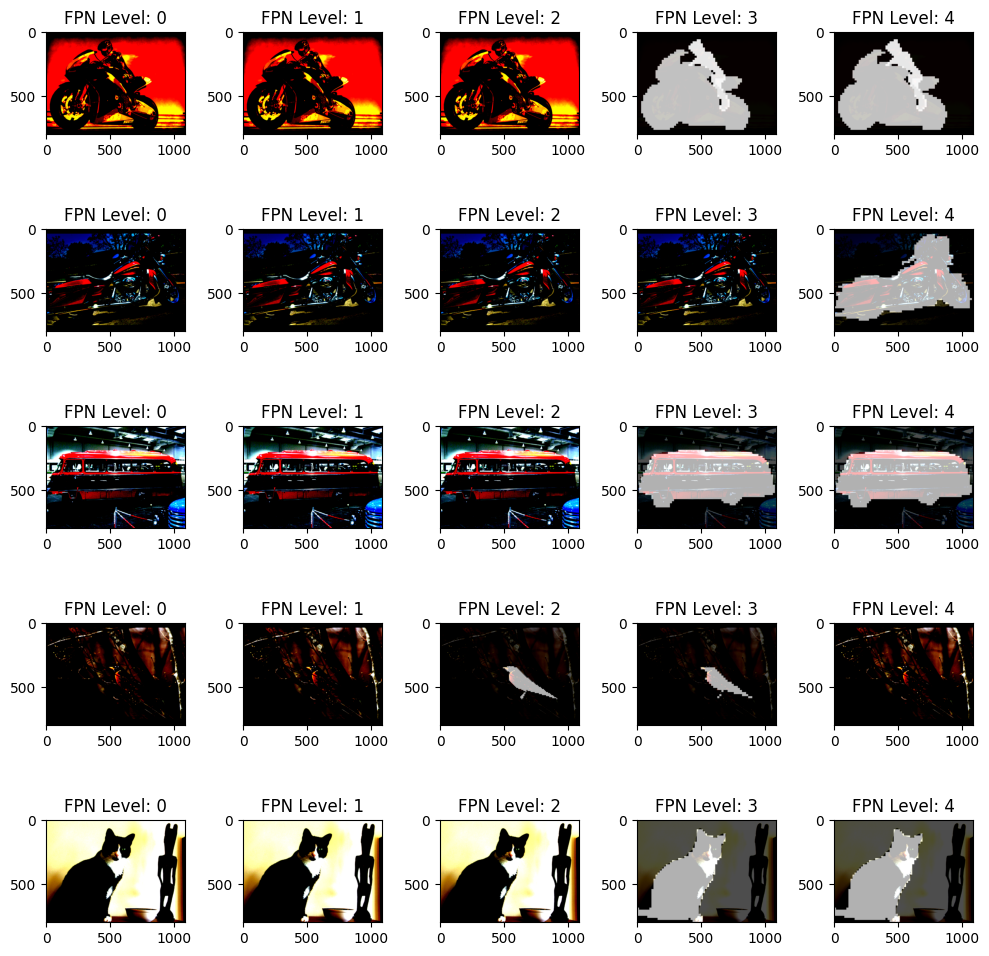

In [9]:
model = SOLO()

category_targets, mask_targets, active_masks, _ = model.generate_targets(batch[3], batch[1], batch[2])
category_targets, mask_targets, active_masks = model.fill_empty_tensors(category_targets, mask_targets, active_masks)
model.plot(batch[0], category_targets, mask_targets, active_masks)

### Part A Submission
In addition to the code you used, you should submit a pdf containing the following plots:
* Dataset visualization plots such as fig. 5 and 6. You should include at least five examples and at least two examples that contain multiple objects. Additionally, the images should cover a range of scales and object classes.
* Target assignment plots such as fig. 8 and 9. Should include at least five examples and at least two examples that contain multiple objects. Additionally, the images should cover a range of scales and object classes.

We should be able to reproduce your results with a single function call or cell evaluation. Please specify the method to do so.

## Part B
### Loss
The loss function consists of two parts: category loss and mask loss:
$$L = \lambda_\text{cate} L_\text{cate} + \lambda_\text{mask} L_\text{mask} $$

The category loss is defined as (where $\text{FL}$ is the focal loss)

$$L_\text{cate} = \frac{1}{S^2 C} \sum_{S,S,C} \text{FL}(p_t)$$

$$\text{FL}(p_t) = -\alpha_t (1 - p_t)^\gamma \log{(p_t)}$$

$$(\alpha_t, p_t) = \left\{\begin{array}{lr} (\alpha, \hat{p}) & \text{if }y=1 \\ (1 - \alpha, 1 - \hat{p}) & \text{otherwise}\end{array}\right.$$

while the mask loss is defined as (where $d_\text{mask}$ is the dice loss)

$$L_\text{mask} = \frac{1}{N_\text{positive}} \sum_k \mathbb{1}_{\{p_{i, j} > 0\}} d_\text{mask}(m_k, \hat{m}_k)$$

$$d_\text{mask}(p, q) = 1 - D(p, q)$$

$$D(p, q) = \frac{2 \sum_{x,y}(p_{x,y} \cdot q_{x,y})}{\sum_{x,y}p_{x,y}^2 + \sum_{x,y}q_{x,y}^2}$$

### Post Processing
Post processing consists of three steps: points NMS, concatenation and sorting, and matrix NMS. A summary of each of these steps is provided below. In addition, your final mask prediction should be a binary mask based on the mask thresholding parameter. Some examples of results post-inference are shown in figs. 11-14.


<div><img src="https://github.com/LukasZhornyak/CIS680_files/raw/main/HW3/fig11.png" width=300/></div>
<center>Figure 11: SOLO instance segmentation example.</center>

<div><img src="https://github.com/LukasZhornyak/CIS680_files/raw/main/HW3/fig12.png" width=300/></div>
<center>Figure 12: SOLO instance segmentation example.</center>

<div><img src="https://github.com/LukasZhornyak/CIS680_files/raw/main/HW3/fig13.png" width=300/></div>
<center>Figure 13: SOLO instance segmentation example.</center>

<div><img src="https://github.com/LukasZhornyak/CIS680_files/raw/main/HW3/fig14.png" width=300/></div>
<center>Figure 14: SOLO instance segmentation example.</center>

#### Points NMS
Non-max suppression for the category predictions, applied to each channel sperately. A maxpooling with a kernel size of 2, sample code is included below.

#### Concatenation and Sorting
Here, we merge the predictions across all the FPN levels into a single list of predictions, sorted by their predicted score. This involves rescaling the predicted masks appropriately.

#### Matrix NMS
Inspired by Soft-NMS, MatrixNMS suppresses mask predictions with a lower score based on their similarity to predictions with a higher score in a completely vectorized manner. Sample code is include below.

In [10]:
# Credit to SOLO Author's code
# This function does NMS on the heat map (category_prediction), grid-level
# Input:
#     heat: (batch_size, C-1, S, S)
# Output:
#     (batch_size, C-1, S, S)
def points_nms(heat, kernel=2):
    # kernel must be 2
    hmax = F.max_pool2d(
        heat, (kernel, kernel), stride=1, padding=1)
    keep = (hmax[:, :, :-1, :-1] == heat).float()
    return heat * keep

# This function performs Matrix NMS
# Input:
#     sorted_masks: (n_active, image_h/4, image_w/4)
#     sorted_scores: (n_active,)
# Output:
#     decay_scores: (n_active,)
def MatrixNMS(sorted_masks, sorted_scores, method='gauss', gauss_sigma=0.5):
    n = len(sorted_scores)
    sorted_masks = sorted_masks.reshape(n, -1)
    intersection = torch.mm(sorted_masks, sorted_masks.T)
    areas = sorted_masks.sum(dim=1).expand(n, n)
    union = areas + areas.T - intersection
    ious = (intersection / union).triu(diagonal=1)

    ious_cmax = ious.max(0)[0].expand(n, n).T
    if method == 'gauss':
        decay = torch.exp(-(ious ** 2 - ious_cmax ** 2) / gauss_sigma)
    else:
        decay = (1 - ious) / (1 - ious_cmax)
    decay = decay.min(dim=0)[0]
    return sorted_scores * decay

### Training
#### Optimizer
The SGD optimizer with a weight decay of 1e-4 and a momentum of 0.9 is used. For a batch size of 16, an initial learning rate of 16 is used (this should be scaled appropriately for different batch sizes). You should train for 36 epochs, reducing the learning rate by a factor of 10 at epochs 27 and 33.

#### Data Augemnetation
To achieve better performance, you may wish to explore some data augmentation techniques. You should be able to achieve the necessary performance without any augmentation, however.

#### Checkpointing
Due to the long training time, we highly recommend that you set up regular checkpointing during your training in case your training gets interrupted (e.g. your colab session ending).

### Part B Submission
In addition to the code you used, you should submit a pdf containing the following plots:
* Dataset visualization plots such as fig. 5 and 6. You should include at least five examples and at least two examples that contain multiple objects. Additionally, the images should cover a range of scales and object classes.
* Target assignment plots such as fig. 8 and 9. You should include at least five examples and at least two examples that contain multiple objects. Additionally, the images should cover a range of scales and object classes.
* Final inference results such as figs. 11-14. You should include at least five examples and at least two examples that contain multiple objects. Additionally, the images should cover a range of scales and object classes.
* Training and validation loss curves. These should include the focal loss, dice loss, and total loss as seperate quantities.

In addition, you should include a discussion of any issues you encountered during this project and any changes you made to the siggested architecture. If you made any interesting observations or thoughts about potential improvements, you should also include them here.

* We should be able to reproduce your results with a single function call or cell evaluation. Please specify the method to do so. You do not, however, need to submit your trained weights.
